<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl_2/blob/main/ML_T1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tarea 1. Aprendizaje máquina.**

Caso sencillo. Sean $\{(x_i,y_i)\}_{i=1}^{n}$ datos dados. Supongamos $m<<n$,  y $\{x_i\}_{i=1}^{m}\subset \{x_i\}_{i=1}^{n}$ una muestra aleatoria.

Definimos nuestra funcion de pérdida $$L(\alpha,\sigma)=||Y-\Phi_\sigma \cdot \alpha||^2_2$$

Donde $(\Phi_\sigma)_{i,j}=(\Phi_\sigma)_{i,j}(\sigma_j,x_j,x_i)$, para $i=1,2\ldots,n$, $j=1,2,\ldots,m$

Es decir, $\Phi_\sigma \cdot \alpha : \mathbb{R}^m\longrightarrow \mathbb{R}^n$.

Procederemos resolviendo 2 problemas de manera alternada.

**Problema 1**. Supongamos $\sigma$ conocida y constante. 
En tal caso, el problema $$argmin_{\alpha} L(\alpha)=||Y-\Phi_\sigma \cdot \alpha||^2_2$$
tiene solución trivial dada por $$\nabla_\alpha (L(\alpha))=0$$
$$\Phi_\sigma^t (Y-\Phi_\sigma\alpha)=0$$
$$\alpha=(\Phi_\sigma ^t\Phi_\sigma)^{-1}\Phi_\sigma^t Y$$

**Problema 2**. Supongamos $\alpha$ conocida y constante.
En tal caso, nos interesa resolver el problema $$argmin_{\sigma} L(\sigma)=||Y-\Phi_\sigma \cdot \alpha||^2_2$$
Aquí, para calcular el gradiente, primero notemos que 
$\Phi_\sigma\cdot \alpha =\Phi_\sigma(\sigma)\cdot \alpha$, es decir, es una función de $\sigma$. Si denotamos por $J_\sigma$ a la Jacobiana de esta función, tenemos 
$$\nabla_\sigma (L(\sigma))=(J_\sigma)^t (Y-\Phi_\sigma \cdot \alpha)$$

Obviamos las cuentitas, pero para resolver el problema, utilizaremos algún método de gradiente descendiente. Digamos, el de Nesterov.


De esta manera, podemos intercalar los problemas y obtener sucesiones $\alpha_k$, $\sigma_k$.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

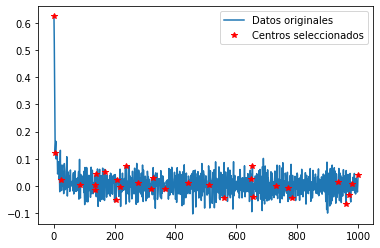

In [4]:
#GD Nesterov-----------------------------------
def GD_N(theta,alpha,eta,nIter, grad,stop_crit=10**(-4)):
    p     = np.zeros(theta.shape)
    Theta=[theta]
    for t in range(nIter):
        pre_theta = theta - 2.0*alpha*p
        g = grad(pre_theta)
        p = 0.5*(g + eta*p)
        if(np.linalg.norm(g)<stop_crit):
            break
        theta = theta - alpha*p
        Theta.append(theta)
    return Theta[-1]
#-----------------------------------
#Datos---------------------Los generamos por comodidad.
np.random.seed(0)
n=1000
x=np.linspace(1,n,n)
y=np.log(x)+np.random.normal(0,.05,size=len(x))
from numpy.random import default_rng
m=30
x_m=[0]*m
x_m[0]=int(x[0]-1)
x_m[-1]=int(x[-1]-1)
x_m[1:-1]=np.sort(default_rng().choice(np.arange(1, len(x)-1), size=m-2, replace=False))
#Diferencias finitas.-------------
y_p=np.zeros(n)
y_p[0]=y[1]-y[0]
y_p[-1]=y[-1]-y[-2]
y_p[1:-2]=(y[2:-1]-y[0:-3])/2
plt.plot(x,y_p,label='Datos originales')
plt.plot(x_m,y_p[x_m],"r*",label='Centros seleccionados')
plt.legend()
plt.show()
#Le vamos a ajustar a los datos y_p.
#-----------------------------


In [5]:
#Matriz Phi--------------------------------
def matriz_phi_sigma(sigma):
    M=np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            M[i,j] = np.exp(-((x[i] -x_m[j])**2)/(2*(sigma[j])**2))*(-(x[i] -x_m[j]))/(sigma[j]**2)
    return M
def solve_for_alphas(M):#Resolver para alphas.
    return np.dot(np.dot(np.linalg.inv(np.dot(M.T,M)),M.T),y)
#---------------------------------

In [6]:
def phi(s,x,x_j):#Funciones reales. phi_{i,j}"
    return np.exp(-((x -x_j)**2)/(2*(s)**2))*(-(x -x_j))/(s**2)
def J_sigma_phi(sigma,alpha):#Jacobiana de la transformacion Phi*alpha como funcion de sigma.
    J=np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            J[i][j]=alpha[j]*((phi(s=sigma[j],x=x[i],x_j=x_m[j]))*((x[i]-x_m[j])**2/sigma[j]**3)*(-(x[i]-x_m[j])/sigma[j]**2)+phi(s=sigma[j],x=x[i],x_j=x_m[j])*(2*(x[i]-x_m[j])/sigma[j]**3))
    return J
#-------------------------------------------

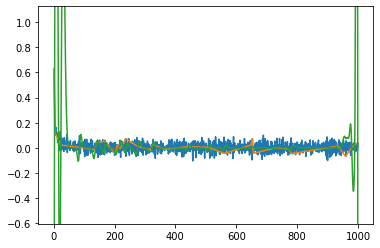

In [20]:
#Funcion de ajuste dado alpha, sigma, x. Con x real--------------------
def F_p_ajuste(sigma,alpha,z):
    sum=0
    for j in range(m):
        sum+=alpha[j]*np.exp(-(1/(2*sigma[j]**2))*(z-x_m[j])**2)*(-(z -x_m[j] ))/(sigma[j]**2)
    return sum
def rutina(nIter,sigma_0,alpha_0):#Repetir los ajustes alternados.
    for r in range(nIter): 
        alpha_0=solve_for_alphas(matriz_phi_sigma(sigma_0))
        def grad_alpha(sigma):
            return np.dot(-J_sigma_phi(sigma=sigma,alpha=alpha_0).T,(y_p-np.dot(matriz_phi_sigma(sigma=sigma),alpha_0)))
        sigma_0=GD_N(theta=sigma_0,alpha=0.001,eta=0.9,nIter=k, grad=grad_alpha,stop_crit=10**(-6))# Llamar a Nesterov 15 veces
    def F_p_ajuste_a_s(W):#Vectorizacion
       R=[]
       for w in W:
           R.append(F_p_ajuste(sigma=sigma_0,alpha=alpha_0,z=w))
       return np.array(R)
    plt.plot(x,y_p)
    plt.plot(x_m,y_p[x_m])
    plt.plot(x,F_p_ajuste_a_s(x))
    plt.axis(ymin=min(y_p)-0.5,ymax=max(y_p)+0.5)
    plt.show()
    return alpha_0,sigma_0
#----------------------------------------
#Condiciones iniciales------------
sigma_0=np.random.normal(5,1,size=m)#A ojo
alpha_0=np.repeat(1,m)#Suma de derivadas de Gaussianas
k=15   #Numero de iteraciones de gradiente descendiente
#-------------------------
alpha_0,sigma_0=rutina(nIter=10,sigma_0=sigma_0,alpha_0=alpha_0)

In [21]:
print(alpha_0)
print(sigma_0)

[-1.00361285e+01 -4.16348037e+01 -2.23522215e+01 -7.31637185e-01
  2.46940604e+00 -3.51919043e+00  5.46018594e-01 -2.53547075e-01
  7.15629659e-02 -4.92462934e-01 -3.98381374e-01 -2.84559888e-01
 -5.39993444e-01 -2.32628929e-01 -2.36825190e-01 -7.69774226e-03
 -1.85949265e-01 -1.89134763e-01 -1.77351727e-01  1.24601695e-02
 -4.38252641e-02  7.63540612e-02 -7.73158877e-02  3.17651530e-02
 -1.97177920e-01  6.97404947e-02  6.61373516e-01  1.28326885e+00
  2.83128462e+00  3.89632753e+01]
[3.60781542 6.13197868 6.89307247 4.17545744 5.42193033 5.54807856
 4.1864367  3.55079055 3.68228714 5.54111635 4.91460429 4.4357881
 5.96675576 5.50811983 4.2444389  3.79879736 5.52325913 4.46241371
 5.09920202 6.5762998  5.50232447 4.13773956 5.16066067 4.04735933
 6.60852072 4.43841008 5.20669652 5.30926386 5.07897529 3.00835414]


En este ejercicio. Estamos asumiendo que los datos proporcionados son las diferencias finitas de algunos datos desconocidos. De esta manera, integrando las funciones $\phi_{i,j}$ podemos obtener un ajuste para los datos originales.

**Nota.** Hacen falta condiciones iniciales, pues al integrar, obtenemos una constante de integración que corresponde a el primer y último valor de muestros datos. Esto último se ve reflejado en el sumando + y[-1]-y[0]

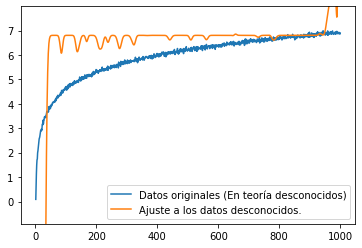

In [23]:
def F_ajuste_original(sigma,alpha,z):#Funcion de ajuste dado alpha, sigma, x. Con x real
    sum=0
    for j in range(m):
        sum+=alpha[j]*np.exp(-(1/(2*sigma[j]**2))*(z-x_m[j])**2)
    return sum
def F_ajuste_a_s_original(W):
       R=[]
       for w in W:
           R.append(F_ajuste_original(sigma=sigma_0,alpha=alpha_0,z=w))
       return np.array(R)
plt.plot(x,y,label='Datos originales (En teoría desconocidos)')
plt.plot(x,F_ajuste_a_s_original(x)+y[-1]-y[0],label='Ajuste a los datos desconocidos.')
plt.axis(ymin=min(y)-1,ymax=max(y)+1)
plt.legend()
plt.show()